

# Load Data


In [ ]:
import pandas as pd

df = pd.read_csv('adult.csv')
display(df.head())

# Explore Data
Visualize the key findings from the initial data exploration of the dataset at "/content/adult.csv".

In [ ]:
display(df.info())
display(df.describe(include='all'))

In [ ]:
numerical_cols = df.select_dtypes(include=['int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numerical variables suitable for visualization:")
for col in numerical_cols:
    print(f"- {col}")

print("\nCategorical variables suitable for visualization:")
for col in categorical_cols:
    print(f"- {col}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

categorical_cols = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex']

for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Frequency')
    plt.ylabel(col)
    plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
top_countries = df['native.country'].value_counts().nlargest(10).index
sns.countplot(data=df[df['native.country'].isin(top_countries)], y='native.country', order=top_countries)
plt.title('Distribution of Top 10 Native Countries')
plt.xlabel('Frequency')
plt.ylabel('Native Country')
plt.show()

### Missing Values Analysis

In [ ]:
missing_counts = (df == "?").sum()
missing_percent = (missing_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    "Missing_Count": missing_counts,
    "Missing_Percent": missing_percent.round(2)
})

nonzero_missing = missing_summary[missing_summary["Missing_Count"] > 0]

plt.figure(figsize=(8, 4))
plt.bar(nonzero_missing.index, nonzero_missing["Missing_Count"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count of '?' values")
plt.title("Missing Value Distribution Across Columns")
plt.tight_layout()
plt.show()

missing_summary

## Summary

### Data Analysis Key Findings

*   The dataset exhibits an imbalanced income distribution, with more individuals earning $\le$50K than >50K.
*   Higher education levels and being in a 'Married-civ-spouse' marital status are strongly associated with a higher likelihood of earning >50K.
*   Certain workclasses ('Self-emp-inc', 'Federal-gov') and occupations ('Exec-managerial', 'Prof-specialty') show a higher proportion of individuals earning >50K.
*   There is a notable gender income disparity, with a significantly higher proportion of males earning >50K compared to females.
*   Working more hours per week generally correlates with a higher chance of earning >50K.
*   Non-zero capital gains are strongly associated with having an income >50K.
*   Missing values appear only in three categorical columns: workclass (5.64%), occupation (5.66%), and native.country (1.79%). All other columns contain no missing entries.



In [ ]:
display(df['income'].value_counts())

Random Forest EDA/Visualization 

In [ ]:
plt.figure(figsize=(12, 8))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [ ]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
for col in ["age", "education.num", "hours.per.week", "capital.gain", "capital.loss"]:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x=col, hue="income", fill=True)
    plt.title(f"{col} Distribution by Income")
    plt.show()

In [ ]:
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    income_rates = df.groupby(col)["income"].value_counts(normalize=True).unstack()
    income_rates.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
    plt.title(f"Income Distribution within {col}")
    plt.ylabel("Proportion")
    plt.legend(title="Income")
    plt.tight_layout()
    plt.show()


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['income'])
plt.title("Income Class Distribution")
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.show()

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    r,k = confusion_matrix.shape
    return np.sqrt(chi2/(n*(min(r,k)-1)))

for col in categorical_cols:
    table = pd.crosstab(df[col], df['income'])
    cv = cramers_v(table.values)
    print(f"Cramer's V between {col} and income: {cv:.3f}")


Preprocessing

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

df_clean = df.replace("?", np.nan)

X = df_clean.drop('income', axis=1)
y = df_clean['income']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("Numeric features used for modeling:")
print(list(numeric_features))
print("\nCategorical features used for modeling:")
print(list(categorical_features))

Numeric features used for modeling:
['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

Categorical features used for modeling:
['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


In [15]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("\nTrain size:", X_train.shape, " Test size:", X_test.shape)


Train size: (26048, 14)  Test size: (6513, 14)


In [16]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"  
)

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", rf_clf)
])

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report (Random Forest):
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      4945
        >50K       0.73      0.61      0.66      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.77      0.78      6513
weighted avg       0.84      0.85      0.85      6513

Confusion Matrix:
[[4587  358]
 [ 614  954]]


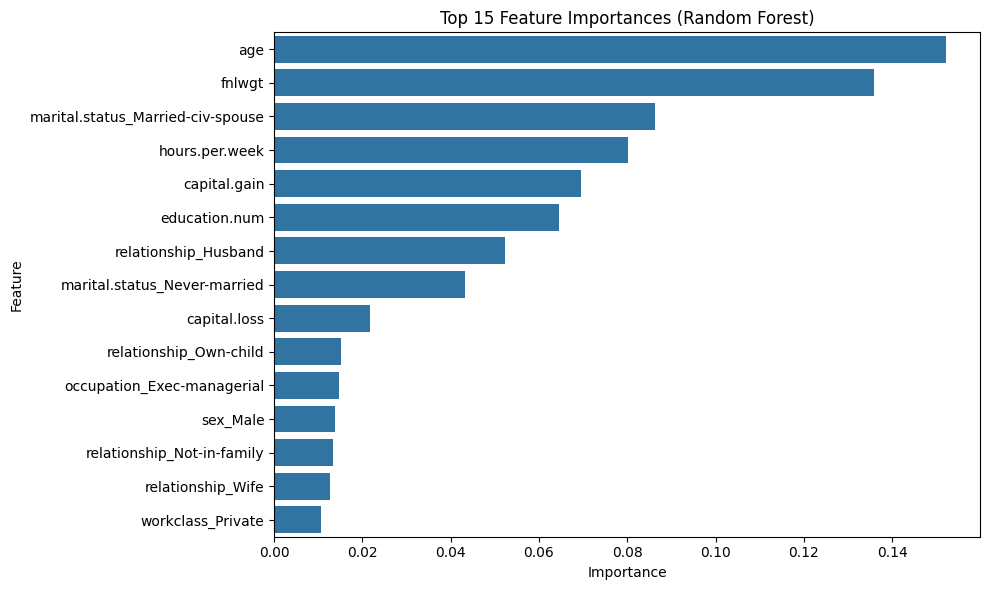

In [ ]:
feature_names_num = list(numeric_features)
feature_names_cat = rf_pipeline.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = rf_pipeline.named_steps["rf"].feature_importances_

indices = np.argsort(importances)[::-1][:15]
top_features = all_feature_names[indices]
top_importances = importances[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()